# Semi Conductor Stock Market Analysis 

Use LSTM to collect and predict future stock prices

Introduction of other factors to the stock analysis process

Stock market prediction based on the performance of other stocks in the market in the same category

Depending on the performance of other stocks such as Nvidia, AMD, etc. then the output should change

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM

# yf.pdr_override() # deprecated

# Single Stock Prediction 

Use just the stock's closing price to predict the next opening price

## Code and Model

In [2]:
def preprocess_data(stock_symbol, epochs=100, batch_size=32, window_size=60):
    # Fetch data
    end = datetime.now()
    start = datetime(end.year - 5, end.month, end.day)

    # Fetch data for multiple stocks for the last 5 years
    df = yf.download(stock_symbol, start=start, end=end)

    # Flatten the column MultiIndex
    df.columns = [col[0] for col in df.columns]  # Keep only the first level of the header

    # Now, 'Close' will be accessible directly
    data = df.filter(['Close'])

    # Convert to numpy array
    dataset = data.values

    # split training data
    training_data_len = int(np.ceil(len(dataset) * .95))

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(dataset)

    X, y = [], []
    for i in range(len(scaled_data) - window_size):
        X.append(scaled_data[i:i+window_size])
        y.append(scaled_data[i+window_size])

    X, y = np.array(X), np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

    # Make predictions
    test_data = scaled_data[training_data_len - window_size:, :]
    test_set = []
    for i in range(window_size, len(test_data)):
        test_set.append(test_data[i-window_size:i, 0])

    test_set = np.array(test_set)
    test_set = np.reshape(test_set, (test_set.shape[0], test_set.shape[1], 1))

    prediction = model.predict(test_set)
    scaled_pred = scaler.inverse_transform(prediction)

    # Prepare results
    valid = data[training_data_len:]
    valid['Predictions'] = scaled_pred

    return df, valid, scaled_pred

In [3]:
df_nvda_5, valid_nvda, pred_nvda = preprocess_data('NVDA')

[*********************100%***********************]  1 of 1 completed


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step


In [4]:
r2 = r2_score(valid_nvda['Close'], valid_nvda['Predictions'])
print(f'R2 Score: {r2}')

R2 Score: 0.8821010789172103


## Output

In [5]:
current_price = df_nvda_5['Close'].iloc[-1]
threshold = 0.03

# predicted_price = float(pred_nvda[-1])
predicted_price = valid_nvda['Predictions'].iloc[-1]

# Decision logic
price_change = (predicted_price - current_price) / current_price  # Calculate % change
if price_change > threshold:
    action = "Buy"
elif price_change < -threshold:
    action = "Sell"
else:
    action = "Hold"

# Print the decision
print(f"Predicted Price: ${predicted_price:.2f}")
print(f"Current Price: ${current_price:.2f}")
print(f"Price Change: {price_change:.2%}")
print(f"Decision: {action}")

Predicted Price: $147.52
Current Price: $145.06
Price Change: 1.69%
Decision: Hold


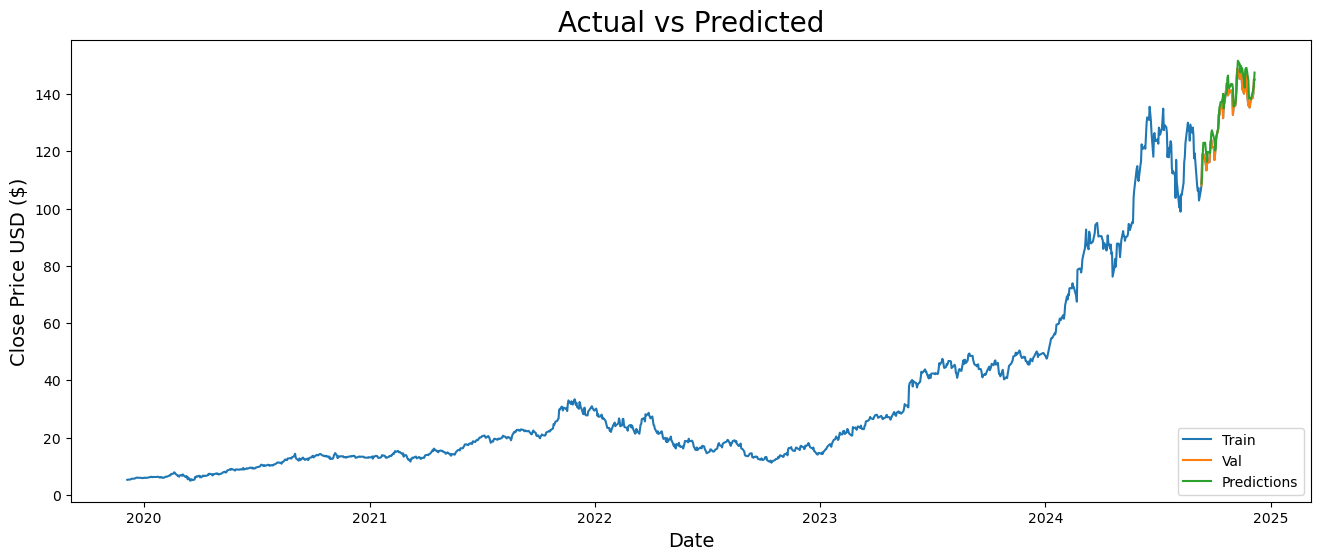

In [6]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Actual vs Predicted', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.plot(df_nvda_5['Close'])
plt.plot(valid_nvda[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# Stock Prediction using influence of other Stocks

Take closing prices of relevent stocks to influence opening stock price calculation for a target stock

## Code and Model

In [7]:
def stock_model(stock_list, target_symbol):
    # Fetch data for multiple stocks for 5 years
    end = datetime.now()
    start = datetime(end.year - 5, end.month, end.day)

    data = yf.download(stock_list, start=start, end=end)

    stock_data = data['Close']

    # Separate the target stock (NVDA) and other stocks
    target_data = stock_data[target_symbol]  
    other_stocks_data = stock_data.drop(columns=[target_symbol]) 

    # Combine the data, get target stock's history based on all other stocks
    dataset = pd.concat([other_stocks_data, target_data], axis=1).values

    # Calculate the length for training data
    training_data_len = int(np.ceil(len(dataset) * .95))

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(dataset)

    window_size = 60 # number of days to consider

    # Prepare the feature (X) and target (y) sequences
    X, y = [], []
    for i in range(len(scaled_data) - window_size):
        X.append(scaled_data[i:i+window_size, :-1])  # All stock data for the window, excluding target stock
        y.append(scaled_data[i+window_size, -1])  # Target stock's next day close price, the last column


    # Convert the lists into numpy arrays
    X, y = np.array(X), np.array(y)

    # 80/20 split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # LSTM model, 4 total layers
    model = Sequential([
        # Recurrent layer of 50 units, enure layer is a sequence, specify shape of input data ((time steps and features)
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        # LSTM 50 units, output is final hidden state summarizing sequential info
        LSTM(50, return_sequences=False),
        # Learns relationships between LSTM output and target
        Dense(25),
        # Predict single numerical value
        Dense(1)
    ])

    # Compile the model with Adam optimizer and Mean Squared Error loss function
    model.compile(optimizer='adam', loss='mse')

    epochs = 100
    batch_size = 32

    # Train
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

    # Make predictions
    test_data = scaled_data[training_data_len - window_size:, :]
    test_set = []
    for i in range(window_size, len(test_data)):
        test_set.append(test_data[i - window_size:i, :-1])  # Use the history of other stocks

    test_set = np.array(test_set)
    test_set = np.reshape(test_set, (test_set.shape[0], test_set.shape[1], test_set.shape[2]))

    # Prediction
    prediction = model.predict(test_set)

    prediction = prediction.reshape(-1, 1)  # Flatten the output for inverse transformation

    # Inverse transform the predictions for the target stock (the last column)
    scaled_pred = scaler.inverse_transform(np.hstack([np.zeros((prediction.shape[0], scaled_data.shape[1] - 1)), prediction]))

    # Prepare results for the target stock
    valid = target_data[training_data_len:]
    valid = valid.to_frame()  # Convert to DataFrame, in the case the data is a series
    valid['Predictions'] = scaled_pred[:, -1]  # Only take the last column for the target stock

    return valid, training_data_len, data


In [8]:
def rec_invest(valid, data, stock):
    # Extract the last prediction as a scalar value
    predicted_price = valid['Predictions'].iloc[-1]

    # Get the current price (last adjusted close price)
    current_price = data['Close'][stock].iloc[-1]

    # Define the threshold
    threshold = 0.03 

    # Decision logic
    price_change = (predicted_price - current_price) / current_price  # Calculate % change
    if price_change > threshold:
        action = "Buy"
    elif price_change < -threshold:
        action = "Sell"
    else:
        action = "Hold"

    # Print the decision
    print(f"Predicted Price: ${predicted_price:.2f}")
    print(f"Current Price: ${current_price:.2f}")
    print(f"Price Change: {price_change:.2%}")
    print(f"Decision: {action}")

In [9]:
def print_visual(data, training_data_len, valid, symbol):
    # Visualize the data
    plt.figure(figsize=(16,6))
    plt.title('Actual vs Predicted', fontsize=20)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Close Price USD ($)', fontsize=14)

    plt.plot(data[:training_data_len]['Close'], color='blue')
    plt.plot(data['Close'][symbol], label='Validation', color='green')
    plt.plot(valid['Predictions'], label='Predictions', color='red')
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True)
    plt.show()

In [10]:
def run_stocks(stock, stock_list):
    valid, trdf, data = stock_model(stock_list, stock)
    rec_invest(valid, data, stock)
    print_visual(data, trdf, valid, stock)

## Output

In [11]:
# 5 years

# semiconductor stocks
# nvidia, taiwan semiconductor manufacturing, broadcom, qualcomm, AMD
semic_stock_list = ['NVDA','TSM', 'AVGO', 'QCOM', 'AMD']

semic_target = 'NVDA'

# faang stocks
# facebook, amazon, apple, netflix, google
faang_stock_list = ['META', 'AMZN', 'AAPL', 'NFLX', 'GOOG']

faang_target = 'META'

## Semi Conductor Stocks

### AMD

In [12]:
valid_amd, trdf_amd, data_amd = stock_model(semic_stock_list, 'AMD')

[*********************100%***********************]  5 of 5 completed


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


In [13]:
rec_invest(valid_amd, data_amd, 'AMD')

Predicted Price: $141.15
Current Price: $141.36
Price Change: -0.15%
Decision: Hold


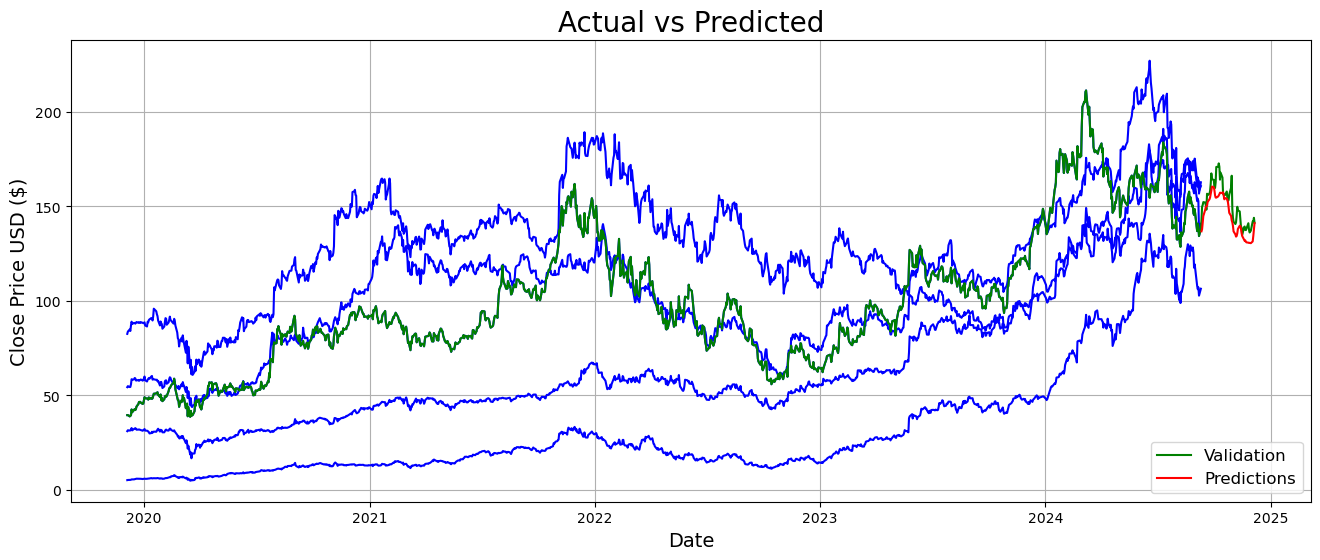

In [14]:
print_visual(data_amd, trdf_amd, valid_amd, 'AMD')

### NVDA

In [15]:
valid_nvda, trdf_nvda, data_nvda = stock_model(semic_stock_list, 'NVDA')

[*********************100%***********************]  5 of 5 completed


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000026356CE8040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step


In [16]:
rec_invest(valid_nvda, data_nvda, 'NVDA')

Predicted Price: $142.69
Current Price: $145.06
Price Change: -1.63%
Decision: Hold


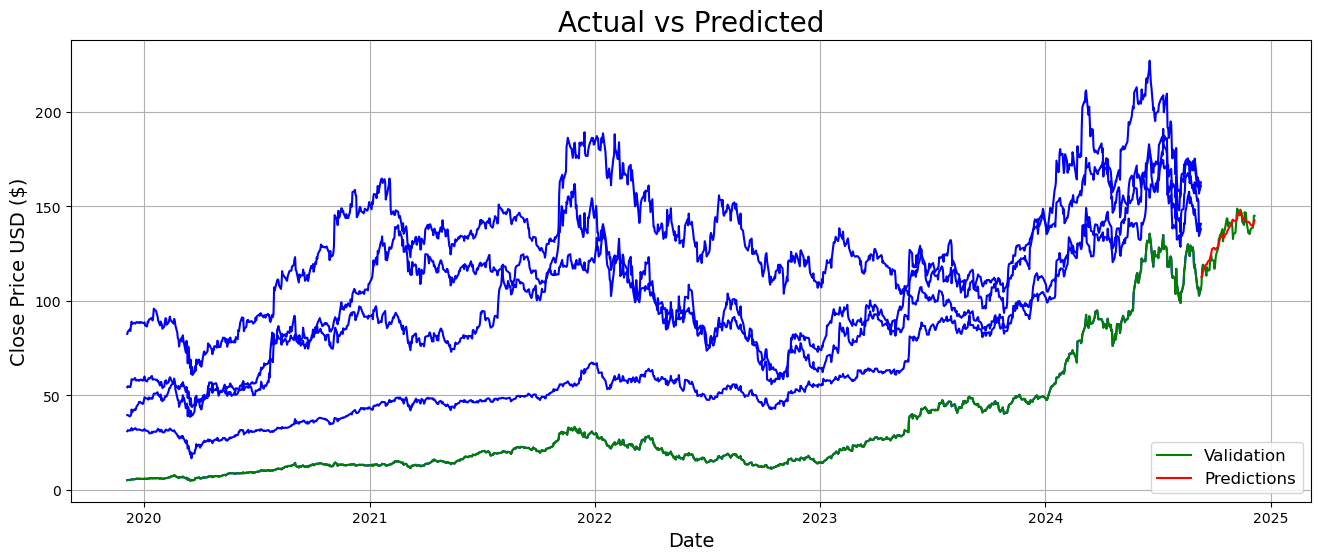

In [17]:
print_visual(data_nvda, trdf_nvda, valid_nvda, 'NVDA')

## Stock list and stock input/output

[*********************100%***********************]  5 of 5 completed


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step
Predicted Price: $601.13
Current Price: $608.93
Price Change: -1.28%
Decision: Hold


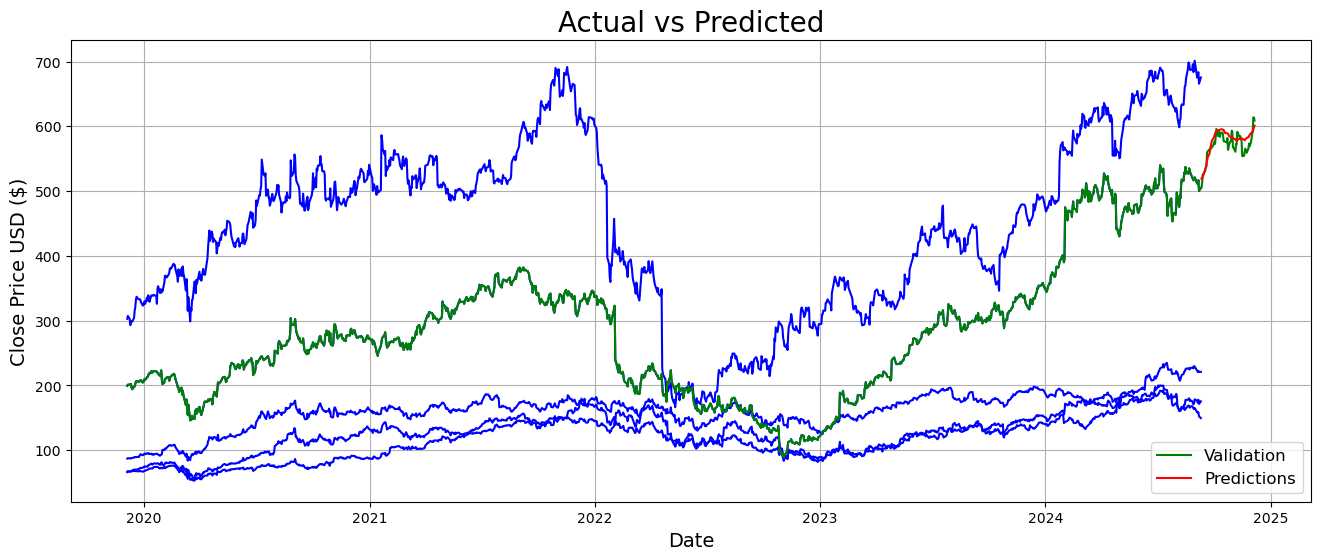

In [18]:
run_stocks(faang_target, faang_stock_list)

[*********************100%***********************]  5 of 5 completed


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step
Predicted Price: $212.80
Current Price: $220.55
Price Change: -3.51%
Decision: Sell


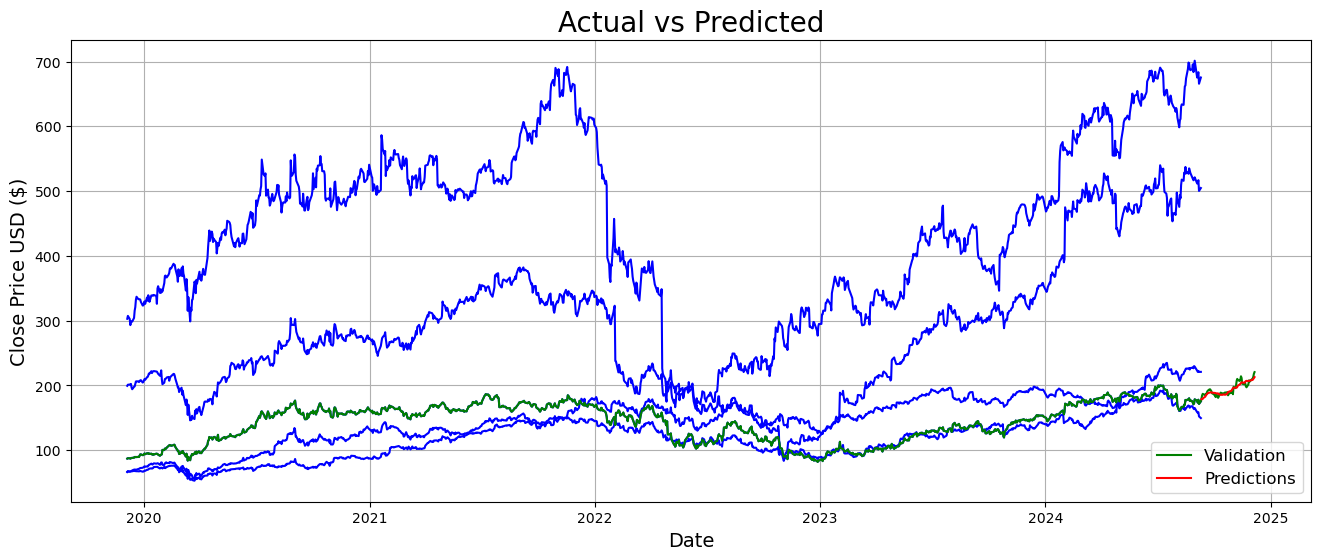

In [19]:
run_stocks('AMZN', faang_stock_list)

[*********************100%***********************]  5 of 5 completed


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step
Predicted Price: $178.14
Current Price: $174.31
Price Change: 2.20%
Decision: Hold


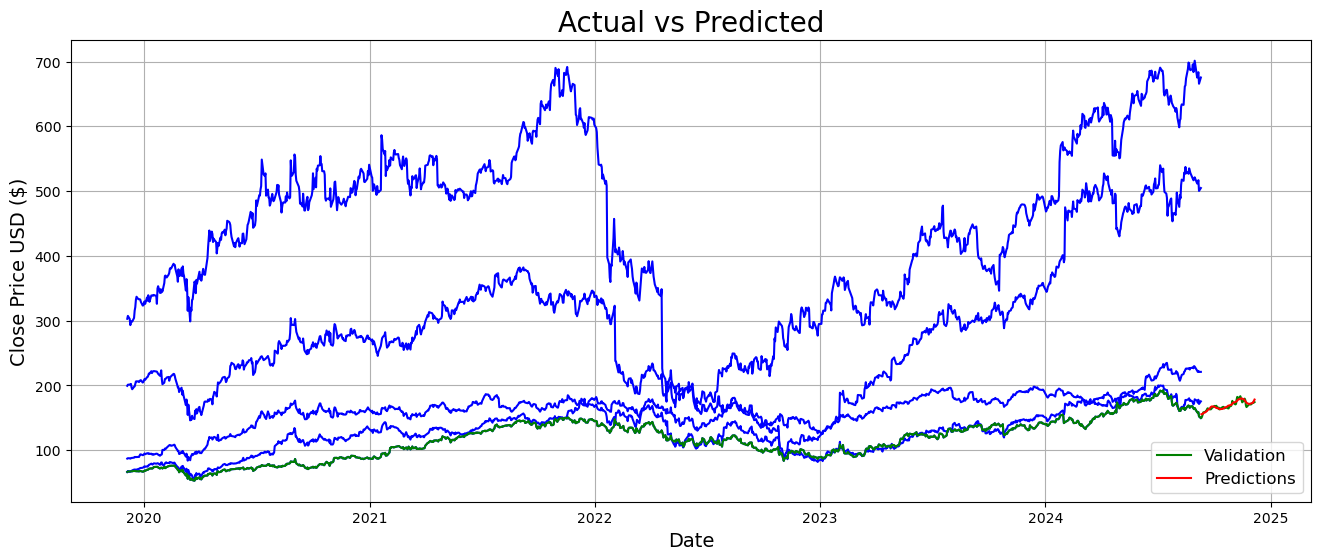

In [20]:
run_stocks('GOOG', faang_stock_list)

[*********************100%***********************]  5 of 5 completed


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step
Predicted Price: $844.58
Current Price: $917.87
Price Change: -7.98%
Decision: Sell


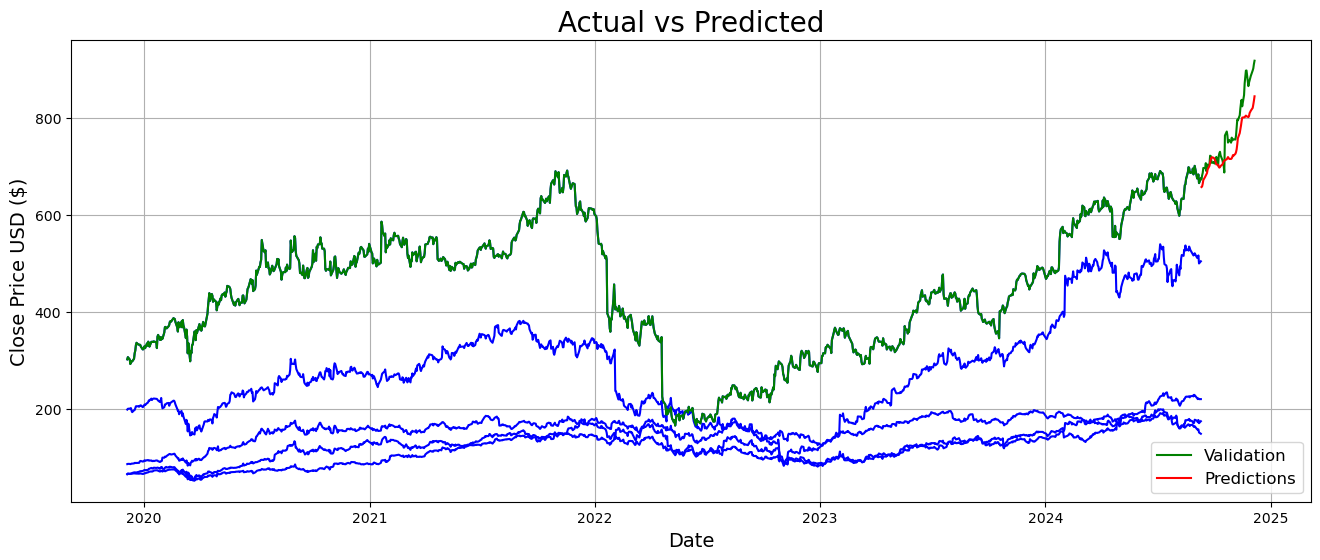

In [21]:
run_stocks('NFLX', faang_stock_list)